# Quantization of Signals

*This jupyter/Python notebook is part of a [collection of notebooks](../index.ipynb) in the masters module [Digital Signal Processing](http://www.int.uni-rostock.de/Digitale-Signalverarbeitung.48.0.html), Comunications Engineering, Universität Rostock. Please direct questions and suggestions to <mailto:Sascha.Spors@uni-rostock.de>.*

## Quantization Error of a Linear Uniform Quantizer

The quantization results in two different types of distortions, as illustrated in the [preceding notebook](linear_uniform_characteristic.ipynb). Overload distortions are a consequence of exceeding the maximum amplitude of the quantizer. Granular distortions are a consequence of the quantization process when no clipping occurs. Various measures are used to quantify the distortions of a given quantizer. We limit ourselves to the Signal-to-Noise ratio.

### Signal-to-Noise Ratio

A quantizer can be evaluated by its [signal-to-noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) (SNR), which is defined as the power of the unquantized signal $x[k]$ divided by the power of the quantization error $e[k]$. Under the assumption that both signals are drawn from a zero-mean weakly stationary process, the average SNR is given as

$$ SNR = 10 \cdot \log_{10} \left( \frac{\sigma_x^2}{\sigma_e^2} \right) \quad \text{ in dB}$$

where $\sigma_x^2$ and $\sigma_e^2$ denote the variances of the signals $x[k]$ and $e[k]$. The statistical properties of the signal $x[k]$ and the quantization error $e[k]$ are required in order to evaluate the SNR of a quantizer.

### Model for the Quantization Error

The statistical properties of the quantization error $e[k]$ have been derived for instance in [[Zölzer](../index.ipynb#Literature)]. We only summarize the results here. We focus on the non-clipping case first, hence on granular distortions. Here the quantization error is in general bounded $|e[k]| < \frac{Q}{2}$.

Under the assumption that the average magnitude of the input signal is much larger that the quantization step size $Q$, the quantization error $e[k]$ can be approximated by the following statistical model and assumptions

1. The quantization error $e[k]$ is not correlated with the input signal $x[k]$

2. The quantization error is [white](../random_signals/white_noise.ipynb)

    $$ \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \sigma_e^2 $$

2. The probability density function (PDF) of the quantization error is given by the zero-mean [uniform distribution](../random_signals/important_distributions.ipynb#Uniform-Distribution)

    $$ p_e(\theta) = \frac{1}{Q} \cdot \text{rect} \left( \frac{\theta}{Q} \right) $$

The variance of the quantization error is then [calculated from its PDF](../random_signals/important_distributions.ipynb#Uniform-Distribution) as

$$ \sigma_e^2 = \frac{Q^2}{12} $$

Let's assume that the quantization index is represented as binary or [fixed-point number](https://en.wikipedia.org/wiki/Fixed-point_arithmetic) with $w$-bits. The common notation for the mid-tread quantizer is that $x_\text{min}$ can be represented exactly. The quantization step is then given as

$$ Q = \frac{ x_\text{max}}{2^{w-1} - 1} = \frac{ |x_\text{min}|}{2^{w-1}}$$

Using this, the variance of the quantization error can be related to the word length $w$

$$ \sigma_e^2 = \frac{x^2_\text{max}}{3 \cdot 2^{2w}} $$

From this result it can be concluded that the power of the quantization error decays by 6 dB per additional bit. This holds only for the assumptions stated above.

### Uniformly Distributed Signal

In order to calculate the average SNR of a linear uniform quantizer, a model for the input signal $x[k]$ is required. Let's assume that the signal is modeled by a zero-mean uniform distribution

$$ p_x(\theta) = \frac{1}{2 x_\text{max}} \text{rect}\left( \frac{\theta}{2 x_\text{max}} \right) $$

Hence, all amplitudes between $-x_\text{max}$ and $x_\text{max}$ occur with the same probability. The variance of the signal is then calculated to

$$ \sigma_x^2 = \frac{4 x_\text{max}^2}{12} $$

Introducing $\sigma_x^2$ and $\sigma_e^2$ into the definition of the SNR yields

$$ SNR = 10 \cdot \log_{10} \left( 2^{2 w} \right) \approx 6.02 \, w \quad \text{in dB} $$

This is often referred to as the 6 dB/bit rule of thumb for quantization. Note that in the derivation above it has been assumed that the signal $x[k]$ uses the full amplitude range of the quantizer. If this is not the case, the SNR will be lower since $\sigma_x^2$ is lower.

#### Example

In this example the linear uniform quantization of a random signal drawn from a uniform distribution is evaluated. The amplitude range of the quantizer is $x_\text{min} = -1$ and $x_\text{max} = 1 - Q$.

SNR = 48.128585 in dB


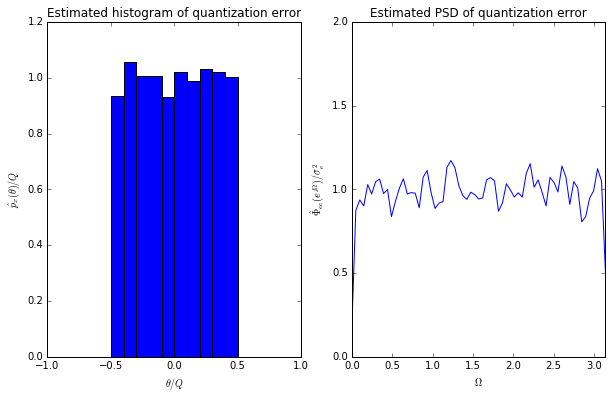

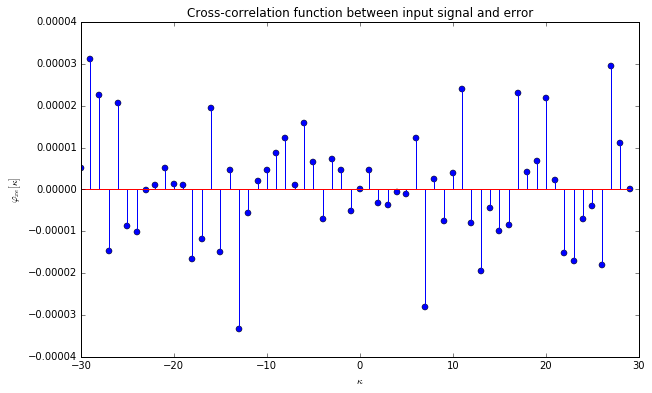

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

w = 8  # wordlength of the quantized signal
A = 1  # amplitude of input signal
N = 8192  # number of samples
K = 30  # maximum lag for cross-correlation


def uniform_midtread_quantizer(x, Q):
    # limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - Q)
    x[idx] = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ

def analyze_quantizer(x, e):
    # estimated PDF of error signal
    pe, bins = np.histogram(e, bins=20, normed=True, range=(-Q, Q))
    # estimate cross-correlation between input and error
    ccf = 1/len(x) * np.correlate(x, e, mode='full')
    # estimate PSD of error signal
    nf, Pee = sig.welch(e, nperseg=128)
    # estimate SNR
    SNR = 10*np.log10((np.var(x)/np.var(e)))
    print('SNR = %f in dB' %SNR)

    # plot statistical properties of error signal
    plt.figure(figsize=(10,6))

    plt.subplot(121)
    plt.bar(bins[:-1]/Q, pe*Q, width = 2/len(pe))
    plt.title('Estimated histogram of quantization error')
    plt.xlabel(r'$\theta / Q$')
    plt.ylabel(r'$\hat{p}_x(\theta) / Q$')
    plt.axis([-1, 1, 0, 1.2])

    plt.subplot(122)
    plt.plot(nf*2*np.pi, Pee*6/Q**2)
    plt.title('Estimated PSD of quantization error')
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$\hat{\Phi}_{ee}(e^{j \Omega}) / \sigma_e^2$')
    plt.axis([0, np.pi, 0, 2]);
    
    plt.figure(figsize=(10,6))
    ccf = ccf[N-K-1:N+K-1]
    kappa = np.arange(-len(ccf)//2,len(ccf)//2)
    plt.stem(kappa, ccf)
    plt.title('Cross-correlation function between input signal and error')
    plt.xlabel(r'$\kappa$')
    plt.ylabel(r'$\varphi_{xe}[\kappa]$')


# quantization step
Q = 1/(2**(w-1))
# compute input signal
x = np.random.uniform(size=N, low=-A, high=(A-Q))
# quantize signal
xQ = uniform_midtread_quantizer(x, Q)
e = xQ - x
# analyze quantizer
analyze_quantizer(x, e)

**Exercise**

* Change the number of bits `w` and check if the derived SNR holds
* Change the amplitude `A` of the input signal. What happens if you make the amplitude very small? Why? 

### Harmonic Signal

For a harmonic input signal $x[k] = x_\text{max} \cdot \cos[\Omega_0 k]$ the variance $\sigma_x^2$ is given by its squared [root mean square](https://en.wikipedia.org/wiki/Root_mean_square) (RMS) value

$$ \sigma_x^2 = \frac{x_\text{max}^2}{2} $$

Introducing this into the definition of the SNR together with the variance $\sigma_e^2$ of the quantization error yields

$$ SNR = 10 \cdot \log_{10} \left(2^{2 w} \cdot \frac{3}{2} \right) \approx 6.02 \, w + 1.76 \quad \text{in dB}$$

The gain of 1.76 dB with respect to the case of a uniformly distributed input signal is due to the fact that the amplitude distribution of a harmonic signal is not uniform

$$ p_x(\theta) = \frac{1}{\pi \sqrt{1 - (\frac{\theta}{x_\text{max}})^2}} $$

for $|\theta| < x_\text{max}$. High amplitudes are more likely to occur. The relative power of the quantization error is lower for higher amplitudes which results in an increase of the average SNR.

### Normally Distributed Signal

So far, we did not consider clipping of the input signal $x[k]$, e.g. by ensuring that its minimum/maximum values do not exceed the limits of the quantizer. However, this cannot always be ensured for practical signals. Moreover, many practical signals cannot be modeled as a uniform distribution. For instance a [normally distributed](../random_signals/important_distributions.ipynb#Normal-Distribution) random signal exceeds a given maximum value with non-zero probability. Hence, clipping will occur for such an input signal. Clipping results in overload distortions whose amplitude can be much higher that $\frac{Q}{2}$. For the overall average SNR both granular and overload distortions have to be included.

For a normally distributed signal with a given probability that clipping occurs $\Pr \{ |x[k]| > x_\text{max} \} = 10^{-5}$ the SNR can be calculated to [[Zölzer](../index.ipynb#Literature)]

$$ SNR \approx 6.02 \, w - 8.5 \quad \text{in dB} $$

The reduction of the SNR by 8.5 dB results from the fact that small signal values are more likely to occur for a normally distributed signal. The relative quantization error for small signals is higher, which results in a lower average SNR. Overload distortions due to clipping result in a further reduction of the average SNR.

### Laplace Distributed Signal

The [Laplace distribution](../random_signals/important_distributions.ipynb#Laplace-Distribution) is a commonly applied model for speech and music signals. As for the normal distribution, clipping will occur with a non-zero probability. For a Laplace distributed signal with a given probability that clipping occurs $\Pr \{ |x[k]| > x_\text{max} \} = 10^{-4}$ the SNR can be calculated to [[Vary et al.](../index.ipynb#Literature)]

$$ SNR \approx 6.02 \, w - 9 \quad \text{in dB} $$

Even though the probability of clipping is higher as for the normally distributed signal above, the SNR is in the same range. The reason for this is, that the Laplace distribution features low signal values with a higher and large values with a lower probability in comparison to the normal distribution.

#### Example

The following example evaluates the SNR of a linear uniform quantizer with $w=8$ for a Laplace distributed signal $x[k]$. The SNR is computed for various probabilities that clipping occurs.

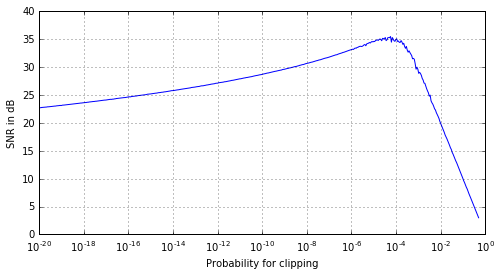

In [2]:
w = 8  # wordlength of the quantized signal
Pc = np.logspace(-20, np.log10(.5), num=500)  # probabilities for clipping
N = int(1e6)  # number of samples


def compute_SNR(Pc):
    # compute input signal
    sigma_x = - np.sqrt(2) / np.log(Pc)
    x = np.random.laplace(size=N, scale=sigma_x/np.sqrt(2) )
    # quantize signal
    xQ = uniform_midtread_quantizer(x, Q)
    e = xQ - x
    # compute SNR
    SNR = 10*np.log10((np.var(x)/np.var(e)))
    
    return SNR


# quantization step
Q = 1/(2**(w-1))
# compute SNR for given probabilities
SNR = [compute_SNR(P) for P in Pc]

# plot results
plt.figure(figsize=(8,4))
plt.semilogx(Pc, SNR)
plt.xlabel('Probability for clipping')
plt.ylabel('SNR in dB')
plt.grid()

**Exercise**

* Can you explain the specific shape of the curve? What effect dominates for clipping probabilities below/obove the maximum? 

**Copyright**

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>